In [538]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

In [539]:
minim = 1e-8

def uniform(u):
    if abs(u) <= 1:
        return 0.5
    return minim


def triangle(u):
    if abs(u) <= 1:
        return 1 - abs(u)
    return minim


def epanechnikov(u):
    if abs(u) <= 1:
        return 3 / 4 * (1 - u ** 2)
    return minim


def quartic(u):
    if abs(u) <= 1:
        return 15 / 16 * (1 - u ** 2) ** 2
    return minim


def triweight(u):
    if abs(u) <= 1:
        return 35 / 32 * (1 - u ** 2) ** 3
    return minim


def tricube(u):
    if abs(u) <= 1:
        return 70 / 81 * (1 - abs(u) ** 3) ** 3
    return minim


def cosine(u):
    if abs(u) <= 1:
        return np.pi / 4 * np.cos(np.pi * u / 2)
    return minim


def gaussian(u):
    return 1 / ((2 * np.pi) ** 0.5) * np.exp(-u ** 2 / 2)


def logistic(u):
    return 1 / (np.exp(u) + 2 + np.exp(-u))


def sigmoid(u):
    return 2 / (np.pi * (np.exp(u) + np.exp(-u)))


def silverman(u):
    return 1 / 2 * np.exp(-abs(u) / (2 ** 0.5)) * np.sin(abs(u) / (2 ** 0.5) + np.pi / 4)


def cosine_dist(a, b):
    return spatial.distance.cosine(a, b)


def minkowski_dist(a, b, p):
    return spatial.distance.minkowski(a, b, p)

In [540]:
kernels = {
    'uniform': uniform,
    'logistic': logistic,
    'triangle': triangle,
    'epanechnikov': epanechnikov,
    'quartic': quartic,
    'triweight': triweight,
    'tricube': tricube,
    'cosine': cosine,
    'gaussian': gaussian,
    'sigmoid': sigmoid,
    'silverman': silverman
}

dists = {
    'cosine': cosine_dist,
    'minkowski': minkowski_dist
}


In [541]:

def calc(dist, kernel, x_train, y_train, point, h=None, k=None, p=None, weights=None):
    K = kernels[kernel]
    d = dists[dist]
    max_sum = -1000
    result1 = None
    b = h is None
    for y in range(4, 8):
        nearest = NearestNeighbors(
            n_neighbors=5 if k is None else k + 1,
            radius=1000000 if h is None else h,
            metric=dist
        )
        nearest.fit(x_train, y_train)
        neighs = nearest.kneighbors(X=point.reshape(1, -1), n_neighbors=50 if k is None else k + 1)
        cur_sum = 0
        if b:
            if dist == 'minkowski':
                h = max(d(x_train[i], point, p) for i in neighs[1][0])
            else:
                h = max(d(x_train[i], point) for i in neighs[1][0])
            if h == 0:
                h = 0.00000000000001
        for i1 in neighs[1][0]:
            if dist == 'minkowski':
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point, p) / h) * (1 if weights is None else weights[i1])
            else:
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point) / h) * (1 if weights is None else weights[i1])
        if cur_sum > max_sum:
            max_sum = cur_sum
            result1 = y
    return result1

In [542]:

def calcWeight(dist, kernel, x_train, y_train, point, h=None, k=None, p=None, weights=None):
    K = kernels[kernel]
    d = dists[dist]
    max_sum = -1000
    result1 = None
    b = h is None
    for y in range(4, 8):
        nearest = NearestNeighbors(
            n_neighbors=5 if k is None else k + 1,
            radius=1000000 if h is None else h,
            metric=dist
        )
        nearest.fit(x_train, y_train)
        neighs = nearest.kneighbors(X=point.reshape(1, -1), n_neighbors=50 if k is None else k + 1)
        cur_sum = 0
        if b:
            if dist == 'minkowski':
                h = max(d(x_train[i], point, p) for i in neighs[1][0])
            else:
                h = max(d(x_train[i], point) for i in neighs[1][0])
            if h == 0:
                h = 0.00000000000001
        for i1 in neighs[1][0]:
            if dist == 'minkowski':
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point, p) / h) * (1 if weights is None else weights[i1])
            else:
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point) / h) * (1 if weights is None else weights[i1])
        if cur_sum > max_sum:
            max_sum = cur_sum
            result1 = y
    return max_sum

In [543]:
def custom_weights(kernel, weights):
    return np.array([kernels[kernel](w) for w in weights[0]]).reshape(1, -1)

def libCalc(dist, kernel, x_train, y_train, point, h=None, k=None, p=None, weights=None):
    knn = KNeighborsClassifier(weights=lambda weights: custom_weights(kernel, weights), n_neighbors=5 if k is None else k + 1, metric=dist)
    knn.fit(x_train, y_train)
    prediction = knn.predict(point.reshape(1, -1))

    return prediction[0]

In [544]:
def calcAll(func, dist, kernel, x_train, y_train, points, h=None, k=None, p=None, weights=None):
    res = []
    for point in points:
        res.append(func(dist, kernel, x_train, y_train, point, h=h, k=k, p=p, weights=weights))
    return res

In [545]:
data = pd.read_csv('winequality-white.csv')
data = data[(data['quality'] != 3) & (data['quality'] != 9)]
x_data = data.drop('quality', axis=1)
y_data = data['quality']
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [546]:
def calcTemplate(trial, func, weights1=None):
    sampled = []
    if(func == libCalc and weights1 is not None):
        for i in range(len(x_train)):
            sampled.append(x_train[i] * weights1[i])
    dist = trial.suggest_categorical('dist', ['cosine', 'minkowski'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'logistic', 'triangle', 'epanechnikov', 'quartic'
                                                  , 'triweight', 'tricube', 'cosine', 'gaussian', 'sigmoid', 'silverman'])
    h = trial.suggest_int('h', 1, 100)
    k = trial.suggest_int('k', 1, 20) if dist != 'minkowski' else None
    p = trial.suggest_int('p', 1, 10) if dist == 'minkowski' else None
    
    res = calcAll(func=func, dist=dist, kernel=kernel, x_train=x_train, y_train=y_train.to_numpy(),
                   points=x_test, h=h, k=k, p=p, weights=weights1)
    
    return mean_squared_error(y_test, res)

In [547]:
def objectiveMy(trial):
    return calcTemplate(trial, calc)

def objectiveLib(trial):
    return calcTemplate(trial, libCalc)

studyLib = optuna.create_study(direction='minimize')
studyLib.optimize(objectiveLib, n_trials=200)

best_params = studyLib.best_params
print("Best parameters for lib version:", best_params)

studyMy = optuna.create_study(direction='minimize')
studyMy.optimize(objectiveMy, n_trials=200)

best_params = studyMy.best_params
print("Best parameters for my version:", best_params)

[I 2024-05-28 14:00:00,667] A new study created in memory with name: no-name-7794544a-01e8-44eb-a4bc-aae54e11eb6a
[I 2024-05-28 14:00:04,162] Trial 0 finished with value: 0.5271794871794871 and parameters: {'dist': 'minkowski', 'kernel': 'tricube', 'h': 2, 'p': 1}. Best is trial 0 with value: 0.5271794871794871.
[I 2024-05-28 14:00:07,987] Trial 1 finished with value: 0.6523076923076923 and parameters: {'dist': 'minkowski', 'kernel': 'logistic', 'h': 39, 'p': 6}. Best is trial 0 with value: 0.5271794871794871.
[I 2024-05-28 14:00:09,091] Trial 2 finished with value: 0.6215384615384615 and parameters: {'dist': 'cosine', 'kernel': 'triangle', 'h': 18, 'k': 6}. Best is trial 0 with value: 0.5271794871794871.
[I 2024-05-28 14:00:10,150] Trial 3 finished with value: 0.6112820512820513 and parameters: {'dist': 'cosine', 'kernel': 'uniform', 'h': 38, 'k': 9}. Best is trial 0 with value: 0.5271794871794871.
[I 2024-05-28 14:00:11,318] Trial 4 finished with value: 0.5938461538461538 and paramet

Best parameters for lib version: {'dist': 'minkowski', 'kernel': 'triangle', 'h': 49, 'p': 7}


[I 2024-05-28 14:11:06,741] Trial 0 finished with value: 0.6256410256410256 and parameters: {'dist': 'minkowski', 'kernel': 'uniform', 'h': 3, 'p': 8}. Best is trial 0 with value: 0.6256410256410256.
[I 2024-05-28 14:11:21,231] Trial 1 finished with value: 0.6153846153846154 and parameters: {'dist': 'minkowski', 'kernel': 'sigmoid', 'h': 30, 'p': 1}. Best is trial 1 with value: 0.6153846153846154.
[I 2024-05-28 14:11:25,821] Trial 2 finished with value: 0.5907692307692308 and parameters: {'dist': 'cosine', 'kernel': 'triangle', 'h': 22, 'k': 20}. Best is trial 2 with value: 0.5907692307692308.
[I 2024-05-28 14:11:29,988] Trial 3 finished with value: 0.5846153846153846 and parameters: {'dist': 'cosine', 'kernel': 'cosine', 'h': 17, 'k': 15}. Best is trial 3 with value: 0.5846153846153846.
[I 2024-05-28 14:11:34,229] Trial 4 finished with value: 0.5774358974358974 and parameters: {'dist': 'cosine', 'kernel': 'tricube', 'h': 29, 'k': 17}. Best is trial 4 with value: 0.5774358974358974.
[I

Best parameters for my version: {'dist': 'minkowski', 'kernel': 'triweight', 'h': 1, 'p': 8}


In [548]:
def compare_accuracy(error_func, x_train, y_train, x_test, y_test, k_values, weights = None):
    calc_accuracy_k = []
    lib_calc_accuracy_k = []

    for k in k_values:
        calc_predictions_k = [calc('cosine', 'silverman', x_train, y_train, point, k=k, weights=weights) for point in x_test]
        lib_calc_predictions_k = [libCalc('cosine', 'silverman', x_train, y_train, point, k=k) for point in x_test]
        calc_accuracy_k.append(error_func(y_test, calc_predictions_k))
        lib_calc_accuracy_k.append(error_func(y_test, lib_calc_predictions_k))

    results_k = pd.DataFrame({
        'k': k_values
        'calc_accuracy': calc_accuracy_k,
        'lib_calc_accuracy': lib_calc_accuracy_k
    })

    plt.figure()
    plt.plot(k_values, calc_accuracy_k, label='calc')
    plt.plot(k_values, lib_calc_accuracy_k, label='libCalc')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy vs. k ')
    plt.show()

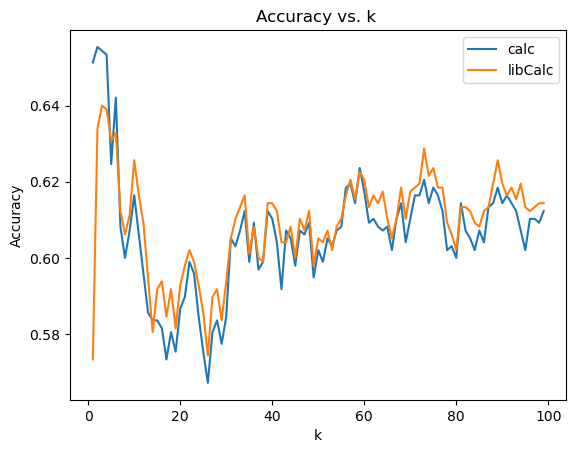

In [549]:
compare_accuracy(
    error_func=mean_squared_error,
    x_train=x_train,
    y_train=y_train.to_numpy(),
    x_test=x_test,
    y_test=y_test.to_numpy(),
    k_values=np.arange(1, 100),
)

In [550]:
def lowess(x_train, y_train, func):
    weights = []
    for i in range(len(x_train)):
        if i < len(x_train):
            d_X = np.delete(x_train, i, axis=0)
            d_y = np.delete(y_train, i, axis=0)
            weight = func('cosine', 'silverman', d_X, d_y, x_train[i], h=None, k=25, p=None)
            weights.append(weight)
    return weights

In [551]:
weights = lowess(x_train, y_train.to_numpy(), calcWeight)
def objectiveMyWeights(trial):
    return calcTemplate(trial, calc, weights)

def objectiveLibWeights(trial):
    return calcTemplate(trial, libCalc, weights)

studyLib = optuna.create_study(direction='minimize')
studyLib.optimize(objectiveLibWeights, n_trials=200)

best_params = studyLib.best_params
print("Best parameters for lib version:", best_params)

studyMy = optuna.create_study(direction='minimize')
studyMy.optimize(objectiveMyWeights, n_trials=200)

best_params = studyMy.best_params
print("Best parameters for my version:", best_params)

[I 2024-05-28 15:01:15,002] A new study created in memory with name: no-name-d98b7d09-5367-4b17-996f-6c64b85cb85a
[I 2024-05-28 15:01:18,448] Trial 0 finished with value: 0.5251282051282051 and parameters: {'dist': 'minkowski', 'kernel': 'cosine', 'h': 86, 'p': 8}. Best is trial 0 with value: 0.5251282051282051.
[I 2024-05-28 15:01:19,485] Trial 1 finished with value: 0.602051282051282 and parameters: {'dist': 'cosine', 'kernel': 'triangle', 'h': 65, 'k': 8}. Best is trial 0 with value: 0.5251282051282051.
[I 2024-05-28 15:01:22,954] Trial 2 finished with value: 0.5261538461538462 and parameters: {'dist': 'minkowski', 'kernel': 'epanechnikov', 'h': 2, 'p': 7}. Best is trial 0 with value: 0.5251282051282051.
[I 2024-05-28 15:01:26,470] Trial 3 finished with value: 0.6523076923076923 and parameters: {'dist': 'minkowski', 'kernel': 'logistic', 'h': 71, 'p': 7}. Best is trial 0 with value: 0.5251282051282051.
[I 2024-05-28 15:01:27,597] Trial 4 finished with value: 0.5917948717948718 and p

Best parameters for lib version: {'dist': 'minkowski', 'kernel': 'triangle', 'h': 37, 'p': 10}


[I 2024-05-28 15:15:32,793] Trial 0 finished with value: 0.6041025641025641 and parameters: {'dist': 'minkowski', 'kernel': 'uniform', 'h': 84, 'p': 10}. Best is trial 0 with value: 0.6041025641025641.
[I 2024-05-28 15:15:36,633] Trial 1 finished with value: 0.7107692307692308 and parameters: {'dist': 'cosine', 'kernel': 'quartic', 'h': 23, 'k': 3}. Best is trial 0 with value: 0.6041025641025641.
[I 2024-05-28 15:15:40,941] Trial 2 finished with value: 0.6605128205128206 and parameters: {'dist': 'cosine', 'kernel': 'tricube', 'h': 47, 'k': 6}. Best is trial 0 with value: 0.6041025641025641.
[I 2024-05-28 15:15:44,783] Trial 3 finished with value: 0.6851282051282052 and parameters: {'dist': 'cosine', 'kernel': 'tricube', 'h': 1, 'k': 2}. Best is trial 0 with value: 0.6041025641025641.
[I 2024-05-28 15:15:49,453] Trial 4 finished with value: 0.6184615384615385 and parameters: {'dist': 'cosine', 'kernel': 'quartic', 'h': 22, 'k': 9}. Best is trial 0 with value: 0.6041025641025641.
[I 2024

Best parameters for my version: {'dist': 'minkowski', 'kernel': 'triweight', 'h': 1, 'p': 1}


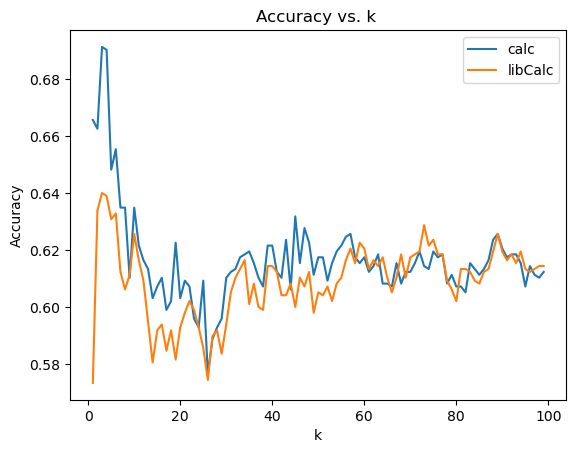

In [552]:
compare_accuracy(
    error_func=mean_squared_error,
    x_train=x_train,
    y_train=y_train.to_numpy(),
    x_test=x_test,
    y_test=y_test.to_numpy(),
    k_values=np.arange(1, 100),
    weights=weights
)